# *CoastSat*: example at Placencia, Belize

There are five main steps:
1. Retrieval of the satellite images of the region of interest from Google Earth Engine
2. Shoreline extraction at sub-pixel resolution
3. Intersection of the shorelines with cross-shore transects
4. Tidal correction 
5. Time-series post-processing
6. Validation against in situ surveys

This software is described in details in the following publications: 
- Shoreline detection:                      https://doi.org/10.1016/j.envsoft.2019.104528
- Accuracy assessment and applications:     https://doi.org/10.1016/j.coastaleng.2019.04.004
- Beach slope estimation:                   https://doi.org/10.1029/2020GL088365

## Initial settings

Refer to the **Installation** section of the README for instructions on how to install the Python packages necessary to run the software, including Google Earth Engine Python API. If that step has been completed correctly, the following packages should be imported without any problem.

In [1]:
%load_ext autoreload
%autoreload 2
import os
import numpy as np
import pickle
import warnings
warnings.filterwarnings("ignore")
import matplotlib
matplotlib.use('Qt5Agg')
import matplotlib.pyplot as plt
from matplotlib import gridspec
plt.ion()
import pandas as pd
from datetime import datetime
from coastsat import SDS_download, SDS_preprocess, SDS_shoreline, SDS_tools, SDS_transects

## 1. Retrieval of the images from GEE

Define the region of interest (`polygon`), the date range (`dates`) and the satellite missions (`sat_list`) from which you wish to retrieve the satellite images. The images will be cropped on the Google Earth Engine server and only the region of interest will be downloaded as a .tif file. The files will stored in the directory defined in `filepath`. 

Make sure the area of your ROI is smaller than 100 km2 (if larger split it into smaller ROIs).

The function `SDS_download.check_images_available(inputs)` will print the number of images available for your inputs. The Landsat images are divided in Tier 1 and Tier 2, only Tier 1 images can be used for time-series analysis.

For Landsat, users can also choose between Collection 1 and Collection 2 with the `collection` variable. Note that from 1st Jan 2022 newly acquired Landsat images are only available in Collection 2, with Landsat 9 only available in Collection 2, so it's preferred that you use Collection 2.

In [3]:
# region of interest (longitude, latitude)
polygon = [[
  [-88.36857704141947, 16.512865760161088],
  [-88.3628716676872, 16.512865760161088],
  [-88.3628716676872, 16.526989431006577],
  [-88.36857704141947, 16.526989431006577],
  [-88.36857704141947, 16.512865760161088]
]]


# it's recommended to convert the polygon to the smallest rectangle (sides parallel to coordinate axes)       
polygon = SDS_tools.smallest_rectangle(polygon)
# date range
dates = ['1990-01-01', '2024-01-01']
# satellite missions ['L5','L7','L8','L9','S2']
sat_list = ['L5']
# choose Landsat collection 'C01' or 'C02'
collection = 'C02'
# name of the site
sitename = 'PLACENCIA'  # NOTE: I think this is just for folder naming
# directory where the data will be stored
filepath = os.path.join(os.getcwd(), 'data')
# put all the inputs into a dictionnary
inputs = {
    'polygon': polygon, 
    'dates': dates, 
    'sat_list': sat_list, 
    'sitename': sitename, 
    'filepath':filepath,
    'landsat_collection': collection
}

# before downloading the images, check how many images are available for your inputs
SDS_download.check_images_available(inputs);

*** Earth Engine *** Share your feedback by taking our Annual Developer Satisfaction Survey: https://google.qualtrics.com/jfe/form/SV_doiqkQG3NJ1t8IS?source=API


Number of images available between 1990-01-01 and 2024-01-01:
- In Landsat Tier 1 & Sentinel-2 Level-1C:
L5
     L5: 350 images
  Total to download: 350 images
- In Landsat Tier 2 (not suitable for time-series analysis):
     L5: 61 images
  Total Tier 2: 61 images


The function `SDS_download.retrieve_images(inputs)` retrives the satellite images from Google Earth Engine.

By default, only Landsat Tier 1 Top-of-Atmosphere and Sentinel-2 Level-1C products are downloaded. 

In case you need to access Tier 2 images for qualitative analysis, you need to set `inputs['include_T2'] = True` before calling `retrieve_images`.

In [27]:
# inputs['include_T2'] = True
metadata = SDS_download.retrieve_images(inputs)

Number of images available between 1990-01-01 and 2024-01-01:
- In Landsat Tier 1 & Sentinel-2 Level-1C:
L5
     L5: 350 images
  Total to download: 350 images
- In Landsat Tier 2 (not suitable for time-series analysis):
     L5: 61 images
  Total Tier 2: 61 images

L5: 350 images
17%
Download failed, trying again...
17%
Download failed, trying again...

Download failed, trying again...

Download failed, trying again...

Download failed, trying again...

Download failed, trying again...

Download failed, trying again...

Download failed, trying again...

Download failed, trying again...

Download failed, trying again...

Download failed, trying again...

Download failed, trying again...



KeyboardInterrupt



**If you have already retrieved the images**, just load the metadata file by only running the section below

In [4]:
metadata = SDS_download.get_metadata(inputs) 

## 2. Shoreline extraction

This section maps the position of the shoreline on the satellite images. The user can define the cloud threhold (`cloud_thresh`) and select the spatial reference system in which to output the coordinates of the mapped shorelines (`output_epsg`). See http://spatialreference.org/ to find the EPSG number corresponding to your local coordinate system. Make sure that your are using **cartesian coordinates and not spherical coordinates (lat,lon)** like WGS84. If unsure, use 3857 which is the web mercator projection (used by Google Maps).

To quality control each shoreline detection and manually validate the mapped shorelines, the user has two options:
1. Set the parameter `check_detection` to `True`: shows each mapped shoreline and user can accept it or discard it.
2. Set the parameter `adjust_detection` to `True` allows the user to adjust the position of the shoreline by modifying the Otsu threshold interactively.

Finally, to save a figure for each mapped shoreline as a .jpg in the folder */jpg_files/detection* set `save_figure` to `True`. 

The other parameters are for advanced users only (which understand what is going on in the background) and are described in the README.

In [5]:
settings = { 
    # general parameters:
    'cloud_thresh': 0.1,        # threshold on maximum cloud cover
    'dist_clouds': 300,         # ditance around clouds where shoreline can't be mapped
    'output_epsg': 28356,       # epsg code of spatial reference system desired for the output
    # quality control:
    'check_detection': True,    # if True, shows each shoreline detection to the user for validation
    'adjust_detection': False,  # if True, allows user to adjust the postion of each shoreline by changing the threhold
    'save_figure': False,        # if True, saves a figure showing the mapped shoreline for each image
    # [ONLY FOR ADVANCED USERS] shoreline detection parameters:
    'min_beach_area': 1000,     # minimum area (in metres^2) for an object to be labelled as a beach
    'min_length_sl': 500,       # minimum length (in metres) of shoreline perimeter to be valid
    'cloud_mask_issue': False,  # switch this parameter to True if sand pixels are masked (in black) on many images  
    'sand_color': 'default',    # 'default', 'latest', 'dark' (for grey/black sand beaches) or 'bright' (for white sand beaches)
    'pan_off': False,           # True to switch pansharpening off for Landsat 7/8/9 imagery
    # add the inputs defined previously
    'inputs': inputs,
}

### [OPTIONAL] Save .jpg of the preprocessed RGB images 
Saves .jpg files of the preprocessed satellite images (cloud masking + pansharpening/down-sampling) under *./data/sitename/jpeg_files\preprocessed*

In [10]:
SDS_preprocess.save_jpg(metadata, settings, use_matplotlib=True)

Saving images as jpg:
L7: 18 images
100%
S2: 38 images
100%
Satellite images saved as .jpg in /home/tylar/repos/CoastSat/data/BELIZE/jpg_files/preprocessed


### [OPTIONAL] Digitize a reference shoreline
Creates a reference shoreline which helps to identify outliers and false detections (HIGHLY RECOMMENDED). The reference shoreline is manually digitised by the user on one of the images. The parameter `max_dist_ref` defines the maximum distance from the reference shoreline (in metres) at which a valid detected shoreline can be. If you think that the default value of 100 m will not capture the full shoreline variability of your site, increase this value to an appropriate distance.

In [10]:
%matplotlib qt
settings['reference_shoreline'] = SDS_preprocess.get_reference_sl(metadata, settings)
settings['max_dist_ref'] = 100 # max distance (in meters) allowed from the reference shoreline

Reference shoreline has been saved in /home/tylar/repos/CoastSat/data/PLACENCIA


### Batch shoreline detection
Extracts the 2D shorelines from the images in the spatial reference system specified by the user in `settings['output_epsg']`. The mapped shorelines are saved into `output.pkl` (under *./data/sitename*) and can also be saved as a `geojson` to be used in a GIS software (see below).

If you see that the sand pixels on the images are not being identified, change the parameter `sand_color` from `default` to `dark` or `bright` depending on the color of your beach. There is also another classifier called `latest` which contains all the training data. These different classifiers only apply to Landsat imagery, for Sentinel-2 there is only one. A new classifier can also be trained as shown in this [example](https://github.com/kvos/CoastSat/blob/master/classification/train_new_classifier.ipynb).

In [6]:
%matplotlib qt
output = SDS_shoreline.extract_shorelines(metadata, settings)

Mapping shorelines:
L5:   100%


Then remove duplicates and images with inaccurate georeferencing (threhsold at 10m)

In [7]:
output = SDS_tools.remove_duplicates(output) # removes duplicates (images taken on the same date by the same satellite)
output = SDS_tools.remove_inaccurate_georef(output, 10) # remove inaccurate georeferencing (set threshold to 10 m)

50 duplicates
0 bad georef


For use in GIS applications, you can save the mapped shorelines as a GEOJSON layer which can be easily imported into QGIS for example. You can choose to save the shorelines as a collection of lines or points (sometimes the lines are crossing over so better to use points).

In [8]:
from pyproj import CRS
geomtype = 'points' # choose 'points' or 'lines' for the layer geometry
gdf = SDS_tools.output_to_gdf(output, geomtype)
if gdf is None:
    raise Exception("output does not contain any mapped shorelines")
gdf.crs = CRS(settings['output_epsg']) # set layer projection
# save GEOJSON layer to file
gdf.to_file(os.path.join(inputs['filepath'], inputs['sitename'], '%s_output_%s.geojson'%(sitename,geomtype)),
                                driver='GeoJSON', encoding='utf-8')

Simple plot of the mapped shorelines. The coordinates are stored in the output dictionnary together with the exact dates in UTC time, the georeferencing accuracy and the cloud cover.

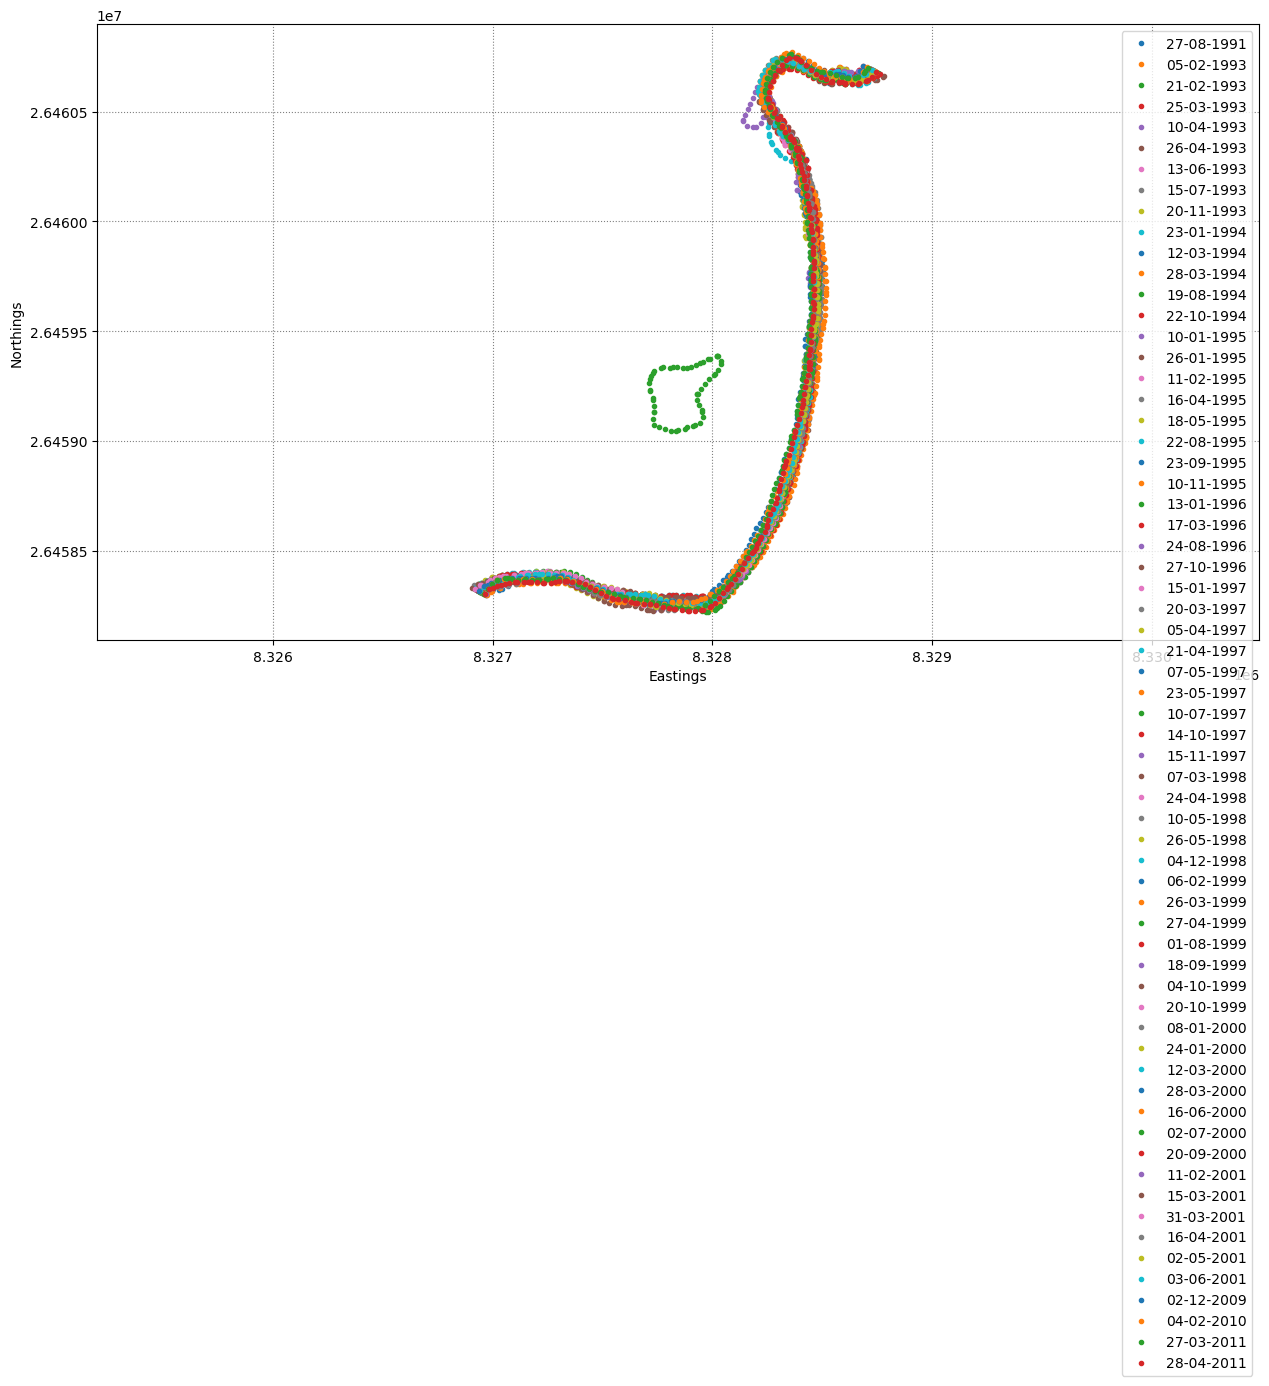

In [9]:
%matplotlib inline
fig = plt.figure(figsize=[15,8])
plt.axis('equal')
plt.xlabel('Eastings')
plt.ylabel('Northings')
plt.grid(linestyle=':', color='0.5')
for i in range(len(output['shorelines'])):
    sl = output['shorelines'][i]
    date = output['dates'][i]
    plt.plot(sl[:,0], sl[:,1], '.', label=date.strftime('%d-%m-%Y'))
plt.legend();

## 3. Shoreline analysis

In this section we show how to compute time-series of cross-shore distance along user-defined shore-normal transects.

**If you have already mapped the shorelines**, just load the output file (`output.pkl`) by running the section below

In [10]:
filepath = os.path.join(inputs['filepath'], sitename)
with open(os.path.join(filepath, sitename + '_output' + '.pkl'), 'rb') as f:
    output = pickle.load(f)
# remove duplicates (images taken on the same date by the same satellite)
output = SDS_tools.remove_duplicates(output)
# remove inaccurate georeferencing (set threshold to 10 m)
output = SDS_tools.remove_inaccurate_georef(output, 10)

50 duplicates
0 bad georef


There are 3 options to define the coordinates of the shore-normal transects:

**Option 1**: the user can interactively draw the shore-normal transects along the beach by calling:

In [13]:
%matplotlib qt
transects = SDS_transects.draw_transects(output, settings)

Transect locations saved in /home/tylar/repos/CoastSat/data/PLACENCIA


**Option 2**: the user can load the transect coordinates (make sure the coordinate reference system (CRS) is the same as defined previously in `settings['output_epsg]`) from a .geojson file by calling:

In [11]:
geojson_file = os.path.join(os.getcwd(), 'examples', 'NARRA_transects.geojson')
transects = SDS_tools.transects_from_geojson(geojson_file)

5 transects have been loaded coordinates are in epsg:28356


**Option 3**: manually provide the coordinates of the transects (in the same CRS as defined in `settings['output_epsg]` as shown in the example below:

In [19]:
transects = dict([])
transects['NA1'] = np.array([[ 342880, 6269180 ], [ 343144, 6269037 ]])
transects['NA2'] = np.array([[ 342733, 6268783 ], [ 343008, 6268664 ]])
transects['NA3'] = np.array([[ 342451, 6267913 ], [ 342746, 6267859 ]])
transects['NA4'] = np.array([[ 342460, 6267042 ], [ 342759, 6267075 ]])
transects['NA5'] = np.array([[ 342675, 6266241 ], [ 342936, 6266388 ]])

Plot the location of the transects, make sure they are in the right location with the origin always landwards! Also check that the transects are intersecting the mapped shorelines.

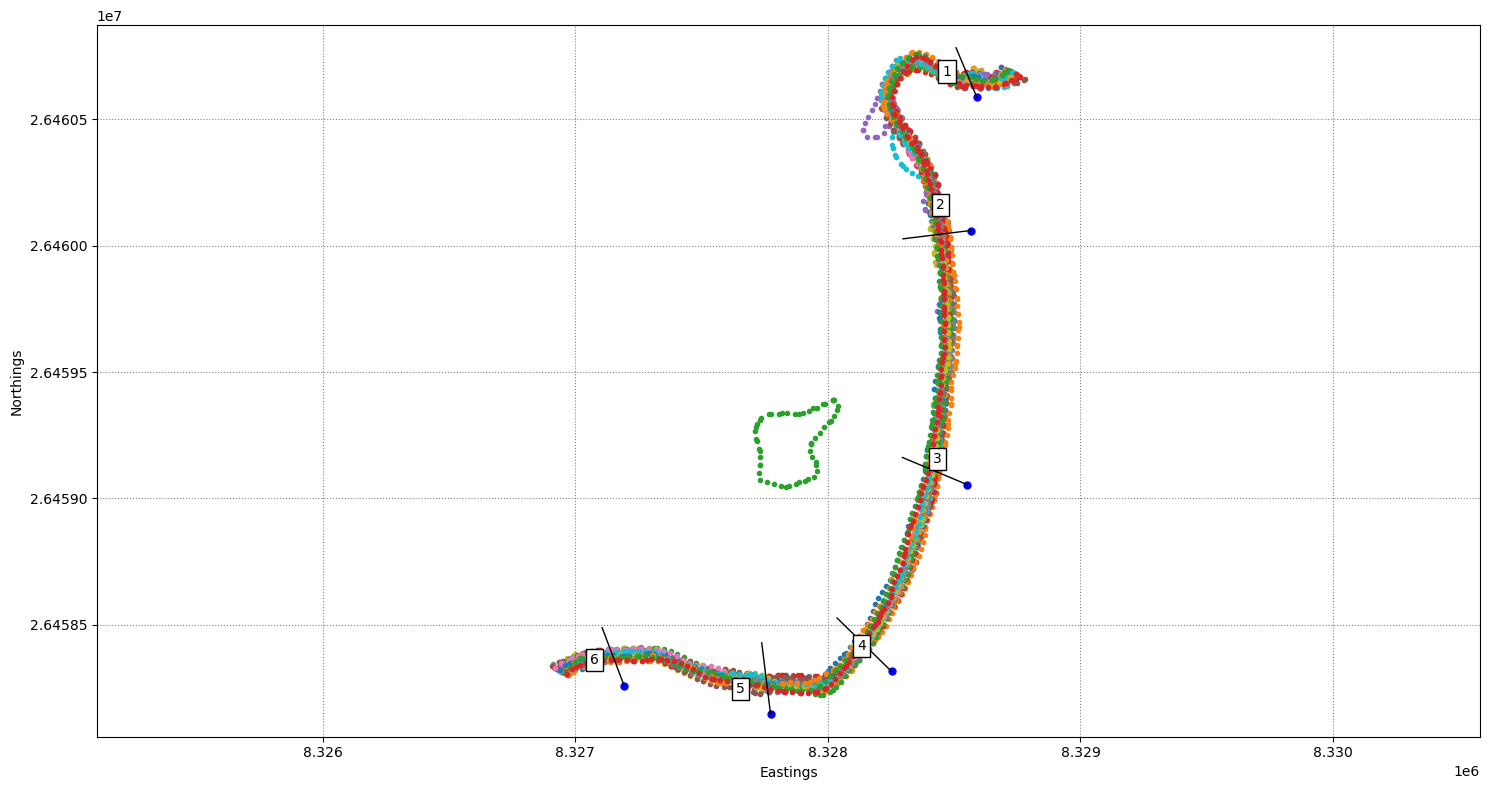

In [21]:
fig = plt.figure(figsize=[15,8], tight_layout=True)
plt.axis('equal')
plt.xlabel('Eastings')
plt.ylabel('Northings')
plt.grid(linestyle=':', color='0.5')
for i in range(len(output['shorelines'])):
    sl = output['shorelines'][i]
    date = output['dates'][i]
    plt.plot(sl[:,0], sl[:,1], '.', label=date.strftime('%d-%m-%Y'))
for i,key in enumerate(list(transects.keys())):
    plt.plot(transects[key][0,0],transects[key][0,1], 'bo', ms=5)
    plt.plot(transects[key][:,0],transects[key][:,1],'k-',lw=1)
    plt.text(transects[key][0,0]-100, transects[key][0,1]+100, key,
                va='center', ha='right', bbox=dict(boxstyle="square", ec='k',fc='w'))
fig

Now, we intersect 2D shorelines with the shore-normal transects to obtain time-series of cross-shore distance along each transect.

One way is to simply compute the intersection as the median of the shoreline points within a certain range (`along_dist`).

In [16]:
# along-shore distance over which to consider shoreline points to compute the median intersection
settings_transects = {'along_dist':25}
cross_distance = SDS_transects.compute_intersection(output, transects, settings_transects) 

However, the shorelines can often be noisy (small loops, double intersections, etc), therefore a few parameters can be set to quality-control the intersections between tranects and shorelines with a more advanced function `compute_intersection_QC()`:
- `along_dist`: (in metres),
    alongshore distance to caluclate the intersection (median of points 
    within this distance). 
- `min_points`:  minimum number of shoreline points to calculate an intersection.
- `max_std`: (in metres) maximum STD for the shoreline points within the alongshore range, 
    if STD is above this value a NaN is returned for this intersection.
- `max_range`: (in metres) maximum RANGE for the shoreline points within the alongshore range, 
    if RANGE is above this value a NaN is returned for this intersection.
- `min_chainage`: (in metres) furthest distance landward of the transect origin that an intersection is 
    accepted, beyond this point a NaN is returned.
- `multiple_inter`: ('auto','nan','max') defines how to deal with multiple shoreline intersections
- `auto_prc`: (value between 0 and 1) by default 0.1, percentage of the time that a multiple intersection needs to be present to use the max in auto mode

Default parameters for the more quality-controlled intersections are provided below and should work in most cases (leave as it is if unsure).

The `multiple_inter` setting helps to deal with multiple shoreline intersections along the same transect. This is quite common, for example when there is a lagoon behind the beach and the transect crosses two water bodies. The function will try to identify this cases and the user can choose whether to:
- `'nan'`: always assign a NaN when there are multile intersections.
- `'max'`: always take the max (intersection the furtherst seaward).
- `'auto'`: let the function decide transect by transect, and if it thinks there are two water bodies, take the max.
If `'auto'` is chosen, the `auto_prc` parameter will define when to use the max, by default it is set to 0.1, which means that the function thinks there are two water bodies if 10% of the time-series show multiple intersections.

In [17]:
settings_transects = { # parameters for computing intersections
                      'along_dist':          25,        # along-shore distance to use for computing the intersection
                      'min_points':          3,         # minimum number of shoreline points to calculate an intersection
                      'max_std':             15,        # max std for points around transect
                      'max_range':           30,        # max range for points around transect
                      'min_chainage':        -100,      # largest negative value along transect (landwards of transect origin)
                      'multiple_inter':      'auto',    # mode for removing outliers ('auto', 'nan', 'max')
                      'auto_prc':            0.1,       # percentage of the time that multiple intersects are present to use the max
                     }
cross_distance = SDS_transects.compute_intersection_QC(output, transects, settings_transects) 

Plot the time-series of shoreline change along each transect

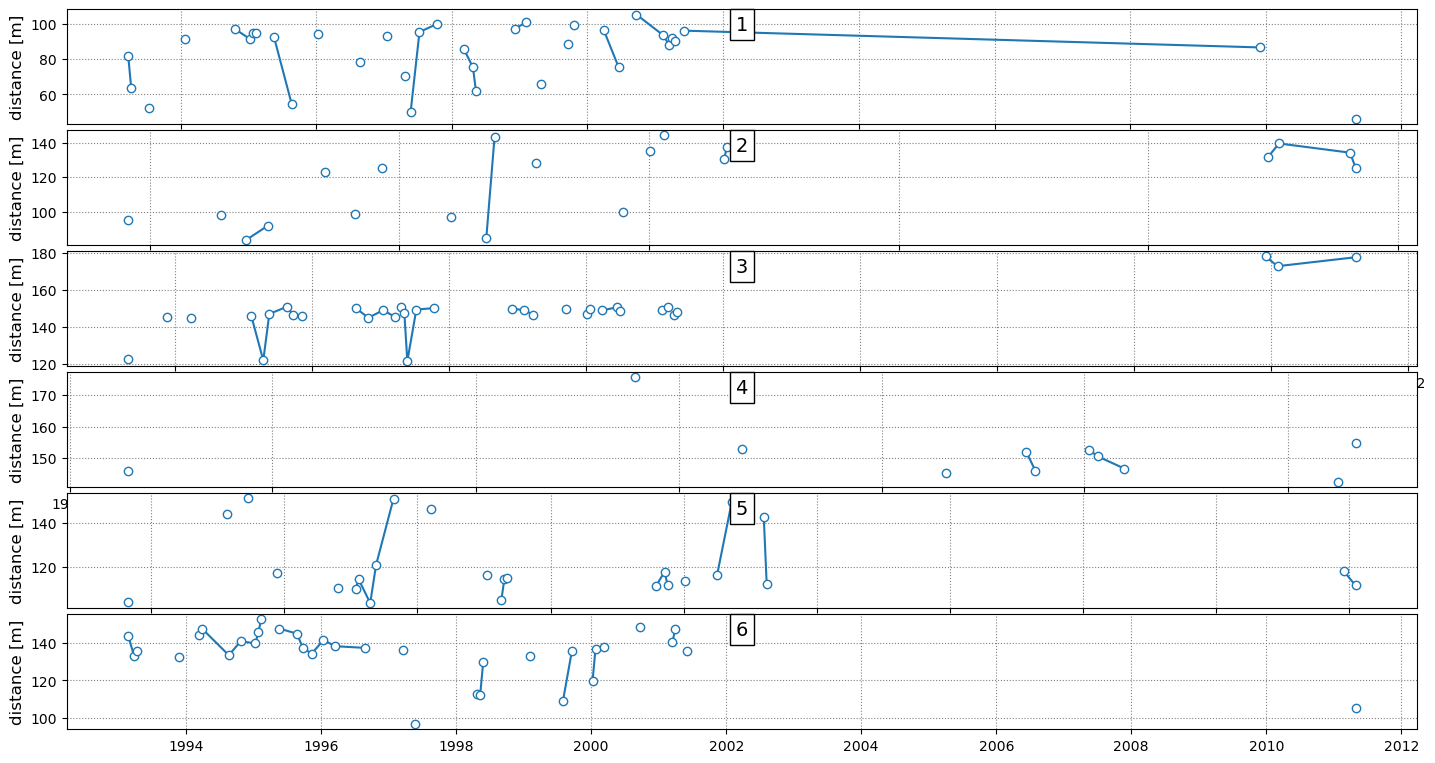

In [20]:
fig = plt.figure(figsize=[15,8], tight_layout=True)
gs = gridspec.GridSpec(len(cross_distance),1)
gs.update(left=0.05, right=0.95, bottom=0.05, top=0.95, hspace=0.05)
for i,key in enumerate(cross_distance.keys()):
    if np.all(np.isnan(cross_distance[key])):
        continue
    ax = fig.add_subplot(gs[i,0])
    ax.grid(linestyle=':', color='0.5')
    ax.plot(output['dates'], cross_distance[key], '-o', ms=6, mfc='w')
    ax.set_ylabel('distance [m]', fontsize=12)
    ax.text(0.5,0.95, key, bbox=dict(boxstyle="square", ec='k',fc='w'), ha='center',
            va='top', transform=ax.transAxes, fontsize=14)  
fig

In [38]:
# save a .csv file for Excel users
out_dict = dict([])
out_dict['dates'] = output['dates']
for key in transects.keys():
    out_dict[key] = cross_distance[key]
df = pd.DataFrame(out_dict)
fn = os.path.join(settings['inputs']['filepath'],settings['inputs']['sitename'],
                  'transect_time_series.csv')
df.to_csv(fn, sep=',')
print('Time-series of the shoreline change along the transects saved as:\n%s'%fn)

Time-series of the shoreline change along the transects saved as:
/home/tylar/repos/CoastSat/data/BELIZE/transect_time_series.csv


## 4. Tidal correction

This last section shows how to tidally-correct the time-series of shoreline change using time-series of tide level and an estimate of the beach slope.

For this example, measured water levels for Sydney are stored in a csv file located [here](https://github.com/kvos/CoastSat/blob/master/examples/NARRA_tides.csv). When using your own file make sure that the dates are in UTC time, as the CoastSat shorelines are also in UTC, and the datum for the water levels is approx. Mean Sea Level.

We assume that the beach slope at Narrabeen-Collaroy is 0.1 along all transects.

**Note**: if you don't have measured water levels and beach slope, it is possible to obtain an estimate of the beach slope and time-series of modelled tide levels at the time of image acquisition from the [FES2014](https://www.aviso.altimetry.fr/es/data/products/auxiliary-products/global-tide-fes/description-fes2014.html) global tide model by using the [CoastSat.slope](https://github.com/kvos/CoastSat.slope) repository (see [this publication](https://doi.org/10.1029/2020GL088365) for more details, open acess preprint [here](https://www.essoar.org/doi/10.1002/essoar.10502903.1)). Instructions on how to install the global tide model are available [here](https://github.com/kvos/CoastSat.slope/blob/master/doc/FES2014_installation.md).

In [21]:
# load the measured tide data
filepath = os.path.join(os.getcwd(),'examples','NARRA_tides.csv')
tide_data = pd.read_csv(filepath)
dates_ts = [pd.to_datetime(_).to_pydatetime() for _ in tide_data['dates']]
tides_ts = np.array(tide_data['tide'])

# get tide levels corresponding to the time of image acquisition
dates_sat = output['dates']
tides_sat = SDS_tools.get_closest_datapoint(dates_sat, dates_ts, tides_ts)

# plot the subsampled tide data
fig, ax = plt.subplots(1,1,figsize=(15,4), tight_layout=True)
ax.grid(which='major', linestyle=':', color='0.5')
ax.plot(dates_ts, tides_ts, '-', color='0.6', label='all time-series')
ax.plot(dates_sat, tides_sat, '-o', color='k', ms=6, mfc='w',lw=1, label='image acquisition')
ax.set(ylabel='tide level [m]',xlim=[dates_sat[0],dates_sat[-1]], title='Water levels at the time of image acquisition');
ax.legend();

Exception: Time-series do not cover the range of your input dates

Apply tidal correction using a linear slope and a reference elevation to which project all the time-series of cross-shore change (to get time-series at Mean Sea Level, set `reference_elevation` to 0. You also need an estimate of the beach slope. 

In [26]:
# tidal correction along each transect
reference_elevation = 0 # elevation at which you would like the shoreline time-series to be
beach_slope = 0.1
cross_distance_tidally_corrected = {}
for key in cross_distance.keys():
    correction = (tides_sat-reference_elevation)/beach_slope
    cross_distance_tidally_corrected[key] = cross_distance[key] + correction
    
# store the tidally-corrected time-series in a .csv file
out_dict = dict([])
out_dict['dates'] = dates_sat
for key in cross_distance_tidally_corrected.keys():
    out_dict[key] = cross_distance_tidally_corrected[key]
df = pd.DataFrame(out_dict)
fn = os.path.join(settings['inputs']['filepath'],settings['inputs']['sitename'],
                  'transect_time_series_tidally_corrected.csv')
df.to_csv(fn, sep=',')
print('Tidally-corrected time-series of the shoreline change along the transects saved as:\n%s'%fn)

# plot the time-series of shoreline change (both raw and tidally-corrected)
fig = plt.figure(figsize=[15,8], tight_layout=True)
gs = gridspec.GridSpec(len(cross_distance),1)
gs.update(left=0.05, right=0.95, bottom=0.05, top=0.95, hspace=0.05)
for i,key in enumerate(cross_distance.keys()):
    if np.all(np.isnan(cross_distance[key])):
        continue
    ax = fig.add_subplot(gs[i,0])
    ax.grid(linestyle=':', color='0.5')
    ax.plot(output['dates'], cross_distance[key], '-o', ms=6, mfc='w', label='raw')
    ax.plot(output['dates'], cross_distance_tidally_corrected[key], '-o', ms=6, mfc='w', label='tidally-corrected')
    ax.set_ylabel('distance [m]', fontsize=12)
    ax.text(0.5,0.95, key, bbox=dict(boxstyle="square", ec='k',fc='w'), ha='center',
            va='top', transform=ax.transAxes, fontsize=14)
ax.legend();

NameError: name 'tides_sat' is not defined

## 5. Time-series post-processing

Finally, we can post-process the time-series of shoreline change to remove obvious outliers and spikes in the data and average the time-series over different time-frames (seasonally or monthly).

To demonstrate these functionalities, we load a full time-series of shoreline change at Narrabeen from Landsat imagery between 1984 and 2021. These shorelines were mapped automatically without manual quality control, intersected with the transects and tidally-corrected.

In [27]:
# load mapped shorelines from 1984
filename_output = os.path.join(os.getcwd(),'examples','NARRA_output.pkl')
with open(filename_output, 'rb') as f:
    output = pickle.load(f) 

# plot the mapped shorelines
fig = plt.figure(figsize=[15,8], tight_layout=True)
plt.axis('equal')
plt.xlabel('Eastings')
plt.ylabel('Northings')
plt.grid(linestyle=':', color='0.5')
plt.title('%d shorelines mapped at Narrabeen from 1984'%len(output['shorelines']))
for i in range(len(output['shorelines'])):
    sl = output['shorelines'][i]
    date = output['dates'][i]
    plt.plot(sl[:,0], sl[:,1], '.', label=date.strftime('%d-%m-%Y'))
for i,key in enumerate(list(transects.keys())):
    plt.plot(transects[key][0,0],transects[key][0,1], 'bo', ms=5)
    plt.plot(transects[key][:,0],transects[key][:,1],'k-',lw=1)
    plt.text(transects[key][0,0]-100, transects[key][0,1]+100, key,
             va='center', ha='right', bbox=dict(boxstyle="square", ec='k',fc='w'))

# load long time-series (1984-2021)
filepath = os.path.join(os.getcwd(),'examples','NARRA_time_series_tidally_corrected.csv')
df = pd.read_csv(filepath, parse_dates=['dates'])
dates = [_.to_pydatetime() for _ in df['dates']]
cross_distance = dict([])
for key in transects.keys():
    cross_distance[key] = np.array(df[key])

#### 5.1 Despiking the time-series

The tidally-corrected time-series of shoreline change obtained with the steps above may still contain some outliers (from cloud shadows, false detections etc). The function `SDS_transects.reject_outliers()` was developed to remove obvious outliers in the time-series, by removing the points that do not make physical sense in a shoreline change setting. 

For example, the shoreline can experience rapid erosion after a large storm, but it will then take time to recover and return to its previous state. Therefore, if the shoreline erodes/accretes suddenly of a significant amount (`max_cross_change`) and then immediately returns to its previous state, this spike does not make any physical sense and can be considered an outlier. Additionally, this funciton also checks that the Otsu thresholds used to map the shoreline are within the typical range defined by `otsu_threshold`, with values outside this range identified as outliers.

In [28]:
# remove outliers in the time-series (coastal despiking)
settings_outliers = {'max_cross_change':   40,             # maximum cross-shore change observable between consecutive timesteps
                     'otsu_threshold':     [-.5,0],        # min and max intensity threshold use for contouring the shoreline
                     'plot_fig':           True,           # whether to plot the intermediate steps
                    }
cross_distance = SDS_transects.reject_outliers(cross_distance,output,settings_outliers)

NA1  - outliers removed: 2
NA2  - outliers removed: 4
NA3  - outliers removed: 3
NA4  - outliers removed: 1
NA5  - outliers removed: 2


We can also plot the Otsu threholds for the shorelines mapped at this site to see if there are any obvious outliers and adjust the values of `otsu_threshold`.

In [29]:
# plot Otsu thresholds for the mapped shorelines
fig,ax = plt.subplots(1,1,figsize=[12,5],tight_layout=True)
ax.grid(which='major',ls=':',lw=0.5,c='0.5')
ax.plot(output['dates'],output['MNDWI_threshold'],'o-',mfc='w')
ax.axhline(y=-0.5,ls='--',c='r',label='otsu_threshold limits')
ax.axhline(y=0,ls='--',c='r')
ax.set(title='Otsu thresholds on MNDWI for the %d shorelines mapped'%len(output['shorelines']),
       ylim=[-0.6,0.2],ylabel='otsu threshold')
ax.legend(loc='upper left')
fig.savefig(os.path.join(inputs['filepath'], inputs['sitename'], 'otsu_threhsolds.jpg'))

#### 5.2 Seasonal averaging and long-term trends

The cell below shows how to calculate seasonal averages on the time-series with `SDS_transects.seasonal_average()` and calculate the long-term trend with `SDS_transects.calculate_trend`.

In [30]:
season_colors = {'DJF':'C3', 'MAM':'C1', 'JJA':'C2', 'SON':'C0'}
for key in cross_distance.keys():
    chainage = cross_distance[key]
    # remove nans
    idx_nan = np.isnan(chainage)
    dates_nonan = [dates[_] for _ in np.where(~idx_nan)[0]]
    chainage = chainage[~idx_nan] 
    
    # compute shoreline seasonal averages (DJF, MAM, JJA, SON)
    dict_seas, dates_seas, chainage_seas, list_seas = SDS_transects.seasonal_average(dates_nonan, chainage)
    
    # calculate long-term trend
    trend, y =  SDS_transects.calculate_trend(dates_seas, chainage_seas)
    
    # plot seasonal averages
    fig,ax=plt.subplots(1,1,figsize=[14,4],tight_layout=True)
    ax.grid(which='major', linestyle=':', color='0.5')
    ax.set_title('Time-series at %s'%key, x=0, ha='left')
    ax.set(ylabel='distance [m]')
    ax.plot(dates_nonan, chainage,'+', lw=1, color='k', mfc='w', ms=4, alpha=0.5,label='raw datapoints')
    ax.plot(dates_seas, chainage_seas, '-', lw=1, color='k', mfc='w', ms=4, label='seasonally-averaged')
    for k,seas in enumerate(dict_seas.keys()):
        ax.plot(dict_seas[seas]['dates'], dict_seas[seas]['chainages'],
                 'o', mec='k', color=season_colors[seas], label=seas,ms=5)
    ax.plot(dates_seas,y,'--',color='b', label='trend %.1f m/year'%trend)
    ax.legend(loc='lower left',ncol=7,markerscale=1.5,frameon=True,edgecolor='k',columnspacing=1)

#### 5.3 Monthly averages

The cell below shows how to calculate seasonal averages on the time-series with `SDS_transects.monthly_average()` and plot them.

In [31]:
month_colors = plt.cm.get_cmap('tab20')
for key in cross_distance.keys():
    chainage = cross_distance[key]
    # remove nans
    idx_nan = np.isnan(chainage)
    dates_nonan = [dates[_] for _ in np.where(~idx_nan)[0]]
    chainage = chainage[~idx_nan] 
    
    # compute shoreline monthly averages
    dict_month, dates_month, chainage_month, list_month = SDS_transects.monthly_average(dates_nonan, chainage)
    
    # plot monthly averages
    fig,ax=plt.subplots(1,1,figsize=[14,4],tight_layout=True)
    ax.grid(which='major', linestyle=':', color='0.5')
    ax.set_title('Time-series at %s'%key, x=0, ha='left')
    ax.set(ylabel='distance [m]')
    ax.plot(dates_nonan, chainage,'+', lw=1, color='k', mfc='w', ms=4, alpha=0.5,label='raw datapoints')
    ax.plot(dates_month, chainage_month, '-', lw=1, color='k', mfc='w', ms=4, label='monthly-averaged')
    for k,month in enumerate(dict_month.keys()):
        ax.plot(dict_month[month]['dates'], dict_month[month]['chainages'],
                 'o', mec='k', color=month_colors(k), label=month,ms=5)
    ax.legend(loc='lower left',ncol=7,markerscale=1.5,frameon=True,edgecolor='k',columnspacing=1)

## 6. Validation against surveys

This section provides a validation of the satellite-derived shorelines at Narrabeen-Collaroy against the survey data, available at http://narrabeen.wrl.unsw.edu.au/download/narrabeen/.

First, you need to download the survey data from the website. Go to the website, click `Download data`, then create a new user and select `Narrabeen Profile Data` as shown below:

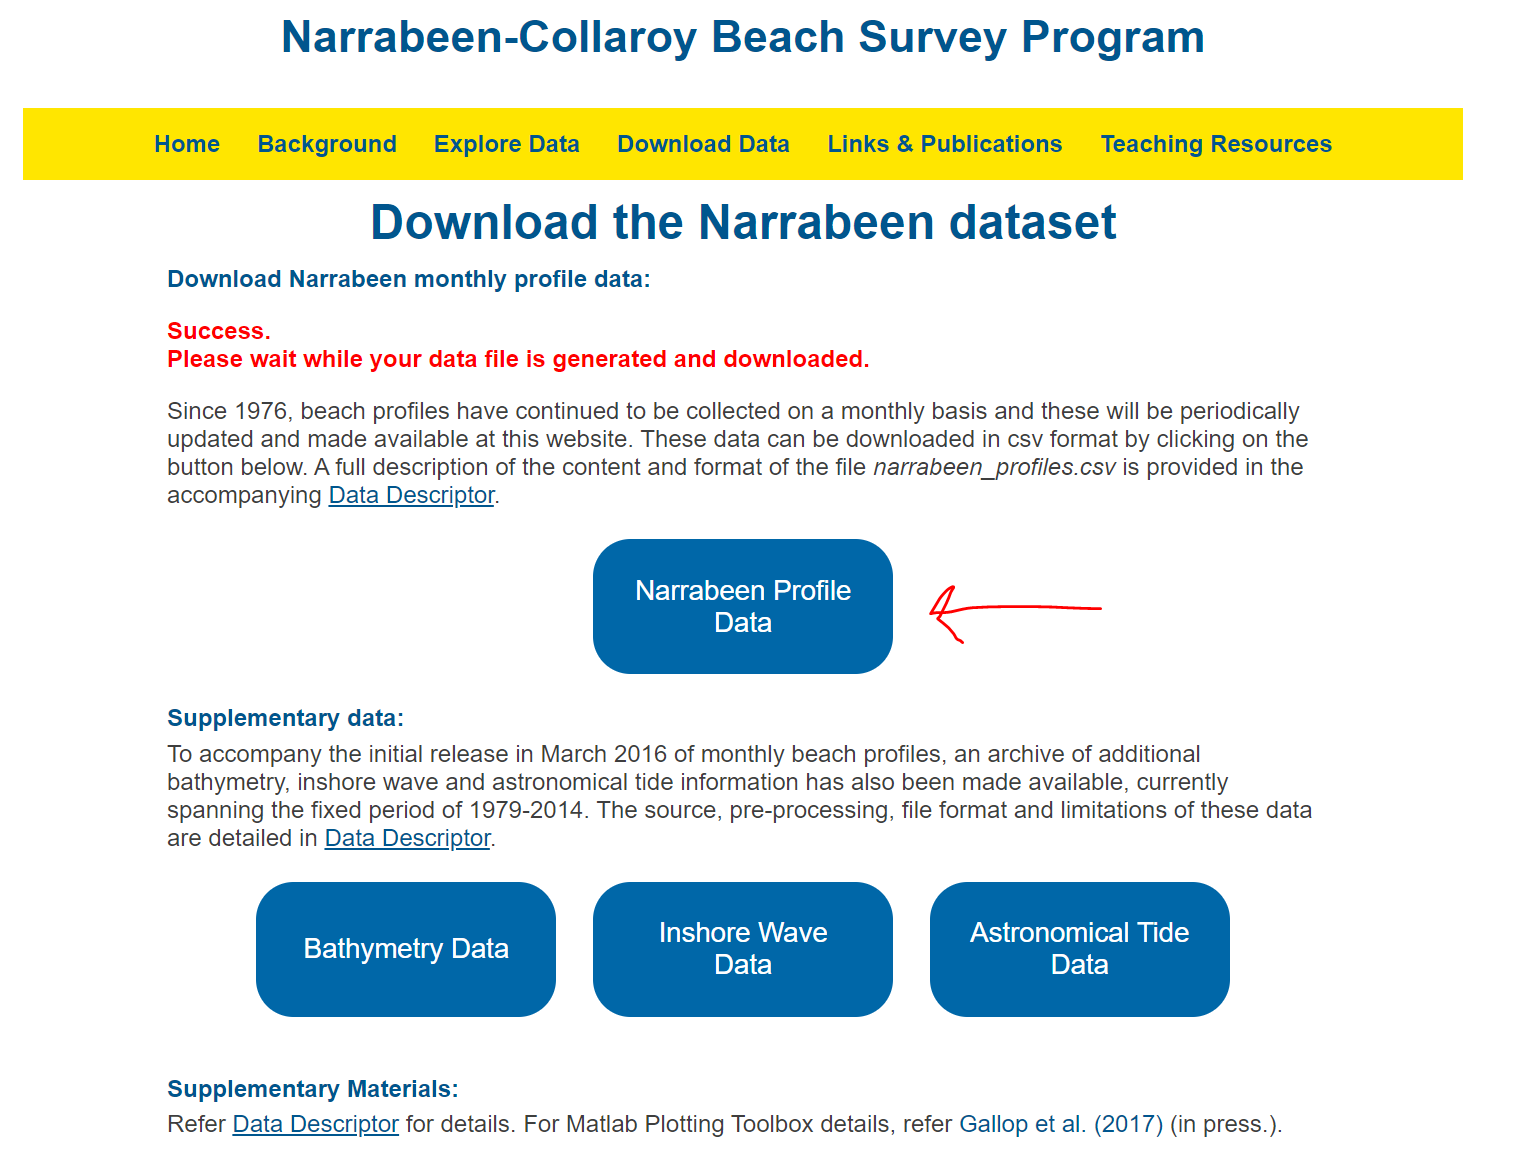

A csv file called `Narrabeen_profiles.csv` will be downloaded, copy it into the `./examples` folder. The code below is used to preprocess the data into time-series of shoreline change at a user-define contour level.

In [32]:
from scipy import interpolate
from scipy import stats
from datetime import timedelta
import pytz
# read the csv file
fp_datasets = os.path.join(os.getcwd(),'examples','Narrabeen_Profiles.csv')
df = pd.read_csv(fp_datasets)
pf_names = list(np.unique(df['Profile ID']))

# select contour level
contour_level = 0.7

# initialise topo_profiles structure
topo_profiles = dict([])
for i in range(len(pf_names)):
     # read dates
    df_pf = df.loc[df['Profile ID'] == pf_names[i]]
    dates_str = df['Date']
    dates_unique = np.unique(dates_str)
    # loop through dates
    topo_profiles[pf_names[i]] = {'dates':[],'chainages':[]}
    for date in dates_unique:
        # extract chainage and elevation for that date
        df_date = df_pf.loc[dates_str == date]
        chainages = np.array(df_date['Chainage'])
        elevations = np.array(df_date['Elevation'])
        if len(chainages) == 0: continue
        # use interpolation to extract the chainage at the contour level
        f = interpolate.interp1d(elevations, chainages, bounds_error=False)
        chainage_contour_level = f(contour_level)
        topo_profiles[pf_names[i]]['chainages'].append(chainage_contour_level)
        date_utc = pytz.utc.localize(datetime.strptime(date,'%Y-%m-%d'))
        topo_profiles[pf_names[i]]['dates'].append(date_utc)

# plot time-series
fig = plt.figure(figsize=[15,8], tight_layout=True)
gs = gridspec.GridSpec(len(topo_profiles),1)
gs.update(left=0.05, right=0.95, bottom=0.05, top=0.95, hspace=0.05)
for i,key in enumerate(topo_profiles.keys()):
    ax = fig.add_subplot(gs[i,0])
    ax.grid(linestyle=':', color='0.5')
    ax.plot(topo_profiles[key]['dates'], topo_profiles[key]['chainages'], '-o', ms=4, mfc='w')
    ax.set_ylabel('distance [m]', fontsize=12)
    ax.text(0.5,0.95, key, bbox=dict(boxstyle="square", ec='k',fc='w'), ha='center',
            va='top', transform=ax.transAxes, fontsize=14)  
# save a .pkl file
with open(os.path.join(os.getcwd(), 'examples', 'Narrabeen_ts_07m.pkl'), 'wb') as f:
    pickle.dump(topo_profiles, f)

FileNotFoundError: [Errno 2] No such file or directory: '/home/tylar/repos/CoastSat/examples/Narrabeen_Profiles.csv'

Now compare the surveys to the satellite-derived shorelines from 1984 loaded previously.

In [33]:
# load survey data
with open(os.path.join(os.getcwd(), 'examples', 'Narrabeen_ts_07m.pkl'), 'rb') as f:
    gt = pickle.load(f)
# change names to mach surveys
for i,key in enumerate(list(cross_distance.keys())):
    key_gt = list(gt.keys())[i]
    cross_distance[key_gt] = cross_distance.pop(key)

# set parameters for comparing the two time-series
sett = {'min_days':3,   # numbers of days difference under which to use nearest neighbour interpolation
        'max_days':10,  # maximum number of days difference to do a comparison
        'binwidth':3,   # binwidth for histogram plotting
        'lims':[-50,50] # cross-shore change limits for plotting purposes
       }

# initialise variables
chain_sat_all = []
chain_sur_all = [] 
satnames_all = []  
for key in cross_distance.keys():
    
    # remove nans
    chainage = cross_distance[key]
    idx_nan = np.isnan(chainage)
    dates_nonans = [output['dates'][k] for k in np.where(~idx_nan)[0]]
    satnames_nonans = [output['satname'][k] for k in np.where(~idx_nan)[0]]
    chain_nonans = chainage[~idx_nan]
    
    chain_sat_dm = chain_nonans
    chain_sur_dm = gt[key]['chainages']
    
    # plot the time-series
    fig= plt.figure(figsize=[15,8], tight_layout=True)
    gs = gridspec.GridSpec(2,3)
    ax0 = fig.add_subplot(gs[0,:])
    ax0.grid(which='major',linestyle=':',color='0.5')
    ax0.plot(gt[key]['dates'], chain_sur_dm, '-',mfc='w',ms=5,label='in situ')
    ax0.plot(dates_nonans, chain_sat_dm,'-',mfc='w',ms=5,label='satellite')
    ax0.set(title= 'Transect ' + key, xlim=[output['dates'][0]-timedelta(days=30),
                                           output['dates'][-1]+timedelta(days=30)])#,ylim=sett['lims'])
    ax0.legend()
    
    # interpolate surveyed data around satellite data
    chain_int = np.nan*np.ones(len(dates_nonans))
    for k,date in enumerate(dates_nonans):
        # compute the days distance for each satellite date 
        days_diff = np.array([ (_ - date).days for _ in gt[key]['dates']])
        # if nothing within 10 days put a nan
        if np.min(np.abs(days_diff)) > sett['max_days']:
            chain_int[k] = np.nan
        else:
            # if a point within 3 days, take that point (no interpolation)
            if np.min(np.abs(days_diff)) < sett['min_days']:
                idx_closest = np.where(np.abs(days_diff) == np.min(np.abs(days_diff)))
                chain_int[k] = float(gt[key]['chainages'][idx_closest[0][0]])
            else: # otherwise, between 3 and 10 days, interpolate between the 2 closest points
                if sum(days_diff > 0) == 0:
                    break
                idx_after = np.where(days_diff > 0)[0][0]
                idx_before = idx_after - 1
                x = [gt[key]['dates'][idx_before].toordinal() , gt[key]['dates'][idx_after].toordinal()]
                y = [gt[key]['chainages'][idx_before], gt[key]['chainages'][idx_after]]
                f = interpolate.interp1d(x, y,bounds_error=True)
                chain_int[k] = float(f(date.toordinal()))
    
    # remove nans again
    idx_nan = np.isnan(chain_int)
    chain_sat = chain_nonans[~idx_nan]
    chain_sur = chain_int[~idx_nan]
    dates_sat = [dates_nonans[k] for k in np.where(~idx_nan)[0]]
    satnames = [satnames_nonans[k] for k in np.where(~idx_nan)[0]]
    chain_sat_all = np.append(chain_sat_all,chain_sat)
    chain_sur_all = np.append(chain_sur_all,chain_sur)
    satnames_all = satnames_all + satnames
    
    # error statistics
    slope, intercept, rvalue, pvalue, std_err = stats.linregress(chain_sur, chain_sat)
    R2 = rvalue**2 
    ax0.text(0,1,'R2 = %.2f'%R2,bbox=dict(boxstyle='square', facecolor='w', alpha=1),transform=ax0.transAxes)
    chain_error = chain_sat - chain_sur
    rmse = np.sqrt(np.mean((chain_error)**2))
    mean = np.mean(chain_error)
    std = np.std(chain_error)
    q90 = np.percentile(np.abs(chain_error), 90)
    
    # 1:1 plot
    ax1 = fig.add_subplot(gs[1,0])
    ax1.axis('equal')
    ax1.grid(which='major',linestyle=':',color='0.5')
    for k,sat in enumerate(list(np.unique(satnames))): 
        idx = np.where([_ == sat for _ in satnames])[0]
        ax1.plot(chain_sur[idx], chain_sat[idx], 'o', ms=4, mfc='C'+str(k),mec='C'+str(k), alpha=0.7, label=sat)
    ax1.legend(loc=4)
    ax1.plot([ax1.get_xlim()[0], ax1.get_ylim()[1]],[ax1.get_xlim()[0], ax1.get_ylim()[1]],'k--',lw=2)
    ax1.set(xlabel='survey [m]', ylabel='satellite [m]')

    # boxplots
    ax2 = fig.add_subplot(gs[1,1])
    data = []
    median_data = []
    n_data = []
    ax2.yaxis.grid()
    for k,sat in enumerate(list(np.unique(satnames))):
        idx = np.where([_ == sat for _ in satnames])[0]
        data.append(chain_error[idx])
        median_data.append(np.median(chain_error[idx]))
        n_data.append(len(chain_error[idx]))
    bp = ax2.boxplot(data,0,'k.', labels=list(np.unique(satnames)), patch_artist=True)
    for median in bp['medians']:
        median.set(color='k', linewidth=1.5)
    for j,boxes in enumerate(bp['boxes']):
        boxes.set(facecolor='C'+str(j))
        ax2.text(j+1,median_data[j]+1, '%.1f' % median_data[j], horizontalalignment='center', fontsize=12)
        ax2.text(j+1+0.35,median_data[j]+1, ('n=%.d' % int(n_data[j])), ha='center', va='center', fontsize=12, rotation='vertical')
    ax2.set(ylabel='error [m]', ylim=sett['lims'])
    
    # histogram
    ax3 = fig.add_subplot(gs[1,2])
    ax3.grid(which='major',linestyle=':',color='0.5')
    ax3.axvline(x=0, ls='--', lw=1.5, color='k')
    binwidth=sett['binwidth']
    bins = np.arange(min(chain_error), max(chain_error) + binwidth, binwidth)
    density = plt.hist(chain_error, bins=bins, density=True, color='0.6', edgecolor='k', alpha=0.5)
    mu, std = stats.norm.fit(chain_error)
    pval = stats.normaltest(chain_error)[1]
    xlims = ax3.get_xlim()
    x = np.linspace(xlims[0], xlims[1], 100)
    p = stats.norm.pdf(x, mu, std)
    ax3.plot(x, p, 'r-', linewidth=1)
    ax3.set(xlabel='error [m]', ylabel='pdf', xlim=sett['lims'])   
    str_stats = ' rmse = %.1f\n mean = %.1f\n std = %.1f\n q90 = %.1f' % (rmse, mean, std, q90) 
    ax3.text(0, 0.98, str_stats,va='top', transform=ax3.transAxes)
    
    # save plot
    fig.savefig(os.path.join(os.getcwd(),'examples','comparison_transect_%s.jpg'%key), dpi=150)


FileNotFoundError: [Errno 2] No such file or directory: '/home/tylar/repos/CoastSat/examples/Narrabeen_ts_07m.pkl'

We can also look at the error statistics for all transects:

In [34]:
# calculate statistics for all transects together
chain_error = chain_sat_all - chain_sur_all        
slope, intercept, rvalue, pvalue, std_err = stats.linregress(chain_sur, chain_sat) 
R2 = rvalue**2
rmse = np.sqrt(np.mean((chain_error)**2))
mean = np.mean(chain_error)
std = np.std(chain_error)
q90 = np.percentile(np.abs(chain_error), 90)

fig,ax = plt.subplots(1,2,figsize=(15,5), tight_layout=True)
# histogram
ax[0].grid(which='major',linestyle=':',color='0.5')
ax[0].axvline(x=0, ls='--', lw=1.5, color='k')
binwidth=sett['binwidth']
bins = np.arange(min(chain_error), max(chain_error) + binwidth, binwidth)
density = ax[0].hist(chain_error, bins=bins, density=True, color='0.6', edgecolor='k', alpha=0.5)
mu, std = stats.norm.fit(chain_error)
pval = stats.normaltest(chain_error)[1]
xlims = ax3.get_xlim()
x = np.linspace(xlims[0], xlims[1], 100)
p = stats.norm.pdf(x, mu, std)
ax[0].plot(x, p, 'r-', linewidth=1)
ax[0].set(xlabel='error [m]', ylabel='pdf', xlim=sett['lims'])   
str_stats = ' rmse = %.1f\n mean = %.1f\n std = %.1f\n q90 = %.1f' % (rmse, mean, std, q90) 
ax[0].text(0, 0.98, str_stats,va='top', transform=ax[0].transAxes,fontsize=14)

# boxplot
data = []
median_data = []
n_data = []
ax[1].yaxis.grid()
for k,sat in enumerate(list(np.unique(satnames_all))):
    idx = np.where([_ == sat for _ in satnames_all])[0]
    data.append(chain_error[idx])
    median_data.append(np.median(chain_error[idx]))
    n_data.append(len(chain_error[idx]))
bp = ax[1].boxplot(data,0,'k.', labels=list(np.unique(satnames_all)), patch_artist=True)
for median in bp['medians']:
    median.set(color='k', linewidth=1.5)
for j,boxes in enumerate(bp['boxes']):
    boxes.set(facecolor='C'+str(j))
    ax[1].text(j+1,median_data[j]+1, '%.1f' % median_data[j], horizontalalignment='center', fontsize=14)
    ax[1].text(j+1+0.35,median_data[j]+1, ('n=%.d' % int(n_data[j])), ha='center', va='center', fontsize=12, rotation='vertical')
ax[1].set(ylabel='error [m]', ylim=sett['lims']);
fig.savefig(os.path.join(os.getcwd(),'examples','comparison_all_transects.jpg'), dpi=150)

NameError: name 'chain_sat_all' is not defined